<a href="https://colab.research.google.com/github/sandhrabijoy/_/blob/master/ARIMA_SARIMA_%26_FBPROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sweetviz
import sweetviz as sv
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [130]:
df= pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Start to Clean and read Data

In [131]:
report = sv.analyze(df)
report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [132]:
def comprehensive_df_overview(dataframe):
  print("##### Shape")
  print(dataframe.shape)
  print("\n##### Data Types")
  print(dataframe.dtypes)
  print("\n###### Columns")
  print(dataframe.columns)
  print("\n##### Index")
  print(dataframe.index)
  print("\n##### Head")
  print(dataframe.head())
  print("\n##### Tail")
  print(dataframe.tail())
  print("\n##### NA")
  print(dataframe.isnull().values.any())
  print("\n###### NA Sum - Ratio")
  print(pd.DataFrame({"na_sum":dataframe.isnull().sum(),"ratio":dataframe.isnull().sum()/dataframe.shape[0]}))
  numeric_cols= dataframe.select_dtypes(include=['number']).columns
  if not numeric_cols.empty:
    print('\n###### Basic Statistics (Numeric Columns)')
    print(dataframe[numeric_cols].describe().T)
    print("\n##### Skewness (Numeric Columns)")
    print(dataframe[numeric_cols].skew())
    print("\n##### Kurtosis (Numeric Columns)")
    print(dataframe[numeric_cols].kurtosis())
    print("\n##### Correlation Matrix (Numeric Columns)")
    print(dataframe[numeric_cols].corr())
  else:
    print("\nNO numeric columns found for statistical analysis")
    non_numeric_cols=dataframe.select_dtypes(exclude=['number']).columns
    if not non_numeric_cols.empty:
      print("\n##### Basic Statistics (Non Numeric Columns)")
      print(dataframe[non_numeric_cols].describe().T)
    else:
      print("\nNo non-numeric columns found for statistical analysis")
    print("\n##### Unique Values per Column")
    print(dataframe.nunique())
    print("\n##### Sample Rows")
    print(dataframe.sample(5))
    print("\n##### Memory Usage")
    print(dataframe.memory_usage(deep=True))

comprehensive_df_overview(df)

##### Shape
(9800, 18)

##### Data Types
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

###### Columns
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

##### Index
RangeIndex(start=0, stop=9800, step=1)

##### Head
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Secon

In [133]:
df=df.drop(columns=["Row ID","Order ID", "Ship Date", "Customer Name", "Country", "Postal Code", "Product Name"])
df.head()

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680


In [134]:
from scipy import stats

def handle_outliers(df, column, threshold=3):
    # Use zscore to calculate z-scores
    z_scores = np.abs(stats.zscore(df[[column]].dropna()))
    # Filter rows based on the threshold
    df = df[(z_scores < threshold).all(axis=1)]
    return df


In [135]:
df=handle_outliers(df,"Sales")

In [136]:
df

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680
...,...,...,...,...,...,...,...,...,...,...,...
9795,21/05/2017,Standard Class,SH-19975,Corporate,Chicago,Illinois,Central,OFF-BI-10003429,Office Supplies,Binders,3.7980
9796,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,OFF-AR-10001374,Office Supplies,Art,10.3680
9797,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10004977,Technology,Phones,235.1880
9798,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10000912,Technology,Phones,26.3760


Prepare for Time Series

In [137]:
df['Order Date']

,Order Date
0,08/11/2017
1,08/11/2017
2,12/06/2017
3,11/10/2016
4,11/10/2016
...,...
9795,21/05/2017
9796,12/01/2016
9797,12/01/2016
9798,12/01/2016


In [138]:
def prepare_for_timeseries(dataframe):
    # Convert 'Order Date' to datetime, handle incomplete or invalid dates with errors='coerce'
    dataframe['Order Date'] = pd.to_datetime(dataframe['Order Date'], format='%d/%m/%Y', errors='coerce')

    # Check for invalid dates (NaT) and handle them
    invalid_dates = dataframe['Order Date'].isnull().sum()
    if invalid_dates > 0:
        print(f"Warning: {invalid_dates} invalid dates found. They will be dropped.")
        dataframe = dataframe.dropna(subset=['Order Date'])

    # Sort by 'Order Date'
    dataframe = dataframe.sort_values(by='Order Date')
    dataframe.reset_index(drop=True, inplace=True)

    print("##### Data Preparation Completed")
    print("\n##### Sorted DataFrame Head")
    print(dataframe.head())

    return dataframe

# Apply the function to your DataFrame
df = prepare_for_timeseries(df)


##### Data Preparation Completed

##### Sorted DataFrame Head
  Order Date       Ship Mode Customer ID      Segment          City  \
0 2015-01-03  Standard Class    DP-13000     Consumer       Houston   
1 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
2 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
3 2015-01-04  Standard Class    PO-19195  Home Office    Naperville   
4 2015-01-05  Standard Class    MB-18085     Consumer  Philadelphia   

          State   Region       Product ID         Category Sub-Category  \
0         Texas  Central  OFF-PA-10000174  Office Supplies        Paper   
1      Illinois  Central  OFF-BI-10004094  Office Supplies      Binders   
2      Illinois  Central  OFF-ST-10002743  Office Supplies      Storage   
3      Illinois  Central  OFF-LA-10003223  Office Supplies       Labels   
4  Pennsylvania     East  OFF-AR-10003478  Office Supplies          Art   

     Sales  
0   16.448  
1    3.540  
2  272.736  
3   11.7

Exploring Data:Numerical,Categorical

In [139]:
def fetch_col_names(dataframe):
    # Categorical columns: columns with object dtype
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']

    # Numerical columns: columns with non-object dtype
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    return cat_cols, num_cols

cat_cols, num_cols = fetch_col_names(df)

In [140]:
cat_cols


['Ship Mode',
 'Customer ID',
 'Segment',
 'City',
 'State',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category']

In [141]:
num_cols

['Order Date', 'Sales']

In [142]:
df['Order Date']

,Order Date
0,2015-01-03
1,2015-01-04
2,2015-01-04
3,2015-01-04
4,2015-01-05
...,...
9672,2018-12-30
9673,2018-12-30
9674,2018-12-30
9675,2018-12-30


In [143]:
def cat_details(dataframe,col_name, plot=False):
  #Count and ration of unique values
  value_counts= dataframe[col_name].value_counts()
  ratio =100 * value_counts/len(dataframe)
  #Length of Summary Line
  summary_length=len(col_name)+len(" Details ")
  border_length=max(50,summary_length + 4)

  #creation of border lines
  top_border = '#'* border_length
  middle_border=f"{'#'*10}{col_name} Details {'#'*10}".center(border_length,'#')
  bottom_border='#'* border_length

  #print summary
  print(f"\n{top_border}")
  print(middle_border)
  print(pd.DataFrame({col_name:value_counts,"Ratio(%)":ratio}))
  print(f"\n{col_name} has {dataframe[col_name].nunique()} unique values.")
  print(f"{bottom_border}\n")

  #Plot countplot if plot is true
  if plot:
    plt.figure(figsize=(10,6))
    plt.bar(value_counts.index, value_counts.values)

    plt.title(f"Count Plot for {col_name}")
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()




##################################################
################Ship Mode Details ################
                Ship Mode   Ratio(%)
Ship Mode                           
Standard Class       5788  59.811925
Second Class         1877  19.396507
First Class          1481  15.304330
Same Day              531   5.487238

Ship Mode has 4 unique values.
##################################################



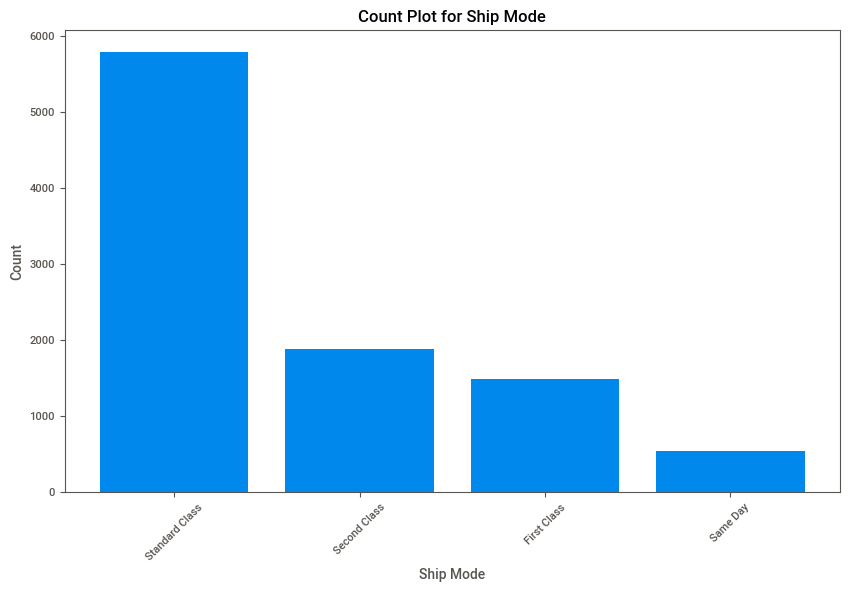


##################################################
#################Segment Details #################
             Segment   Ratio(%)
Segment                        
Consumer        5041  52.092591
Corporate       2917  30.143640
Home Office     1719  17.763770

Segment has 3 unique values.
##################################################



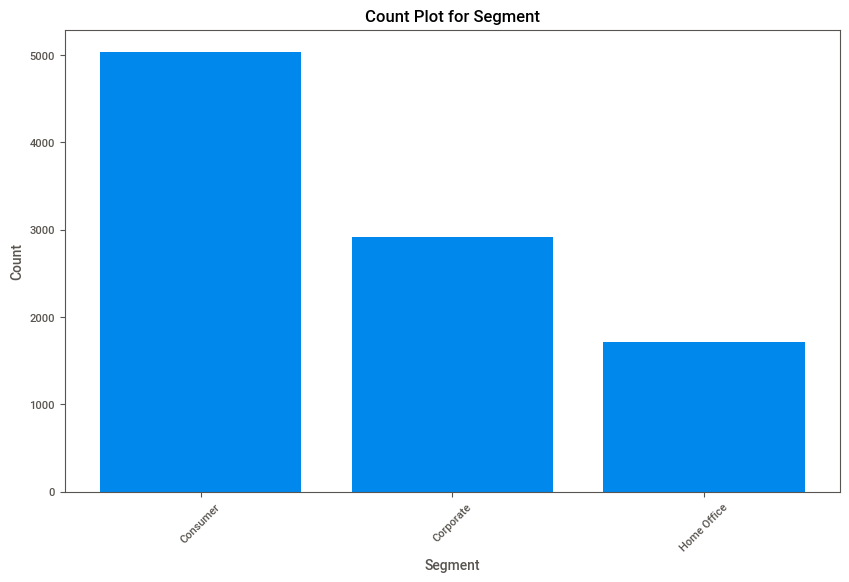


##################################################
##################State Details ##################
                      State   Ratio(%)
State                                 
California             1923  19.871861
New York               1070  11.057146
Texas                   965   9.972099
Pennsylvania            578   5.972925
Washington              496   5.125555
Illinois                481   4.970549
Ohio                    453   4.681203
Florida                 370   3.823499
Michigan                248   2.562778
North Carolina          244   2.521443
Arizona                 223   2.304433
Virginia                218   2.252764
Tennessee               181   1.870414
Colorado                178   1.839413
Georgia                 173   1.787744
Massachusetts           135   1.395060
Kentucky                134   1.384727
Indiana                 133   1.374393
Oregon                  122   1.260721
New Jersey              118   1.219386
Maryland                104   1.074713


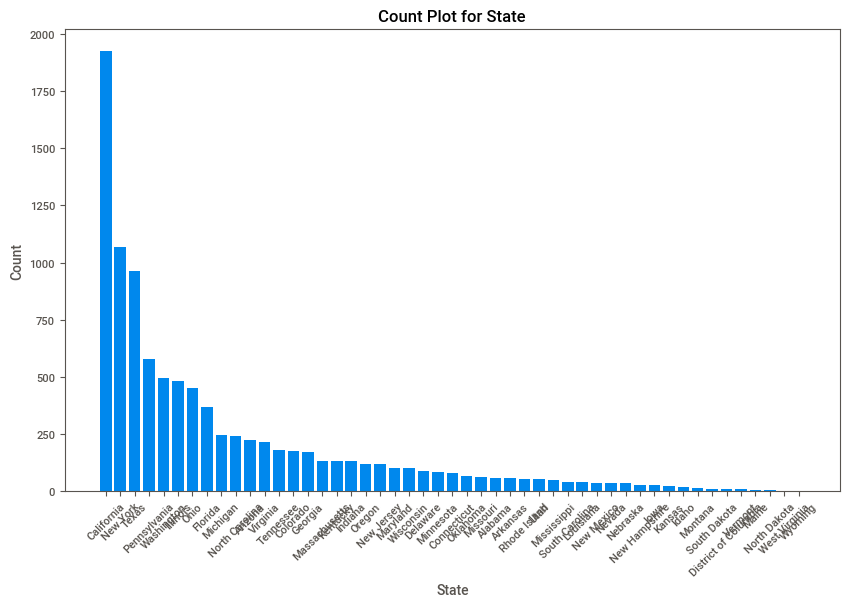


##################################################
#################Region Details ##################
         Region   Ratio(%)
Region                    
West       3105  32.086390
East       2743  28.345562
Central    2254  23.292343
South      1575  16.275705

Region has 4 unique values.
##################################################



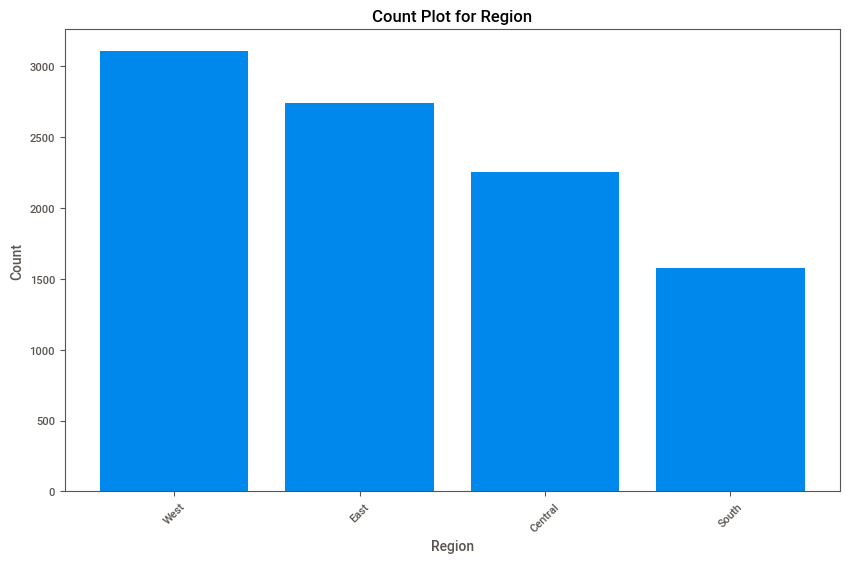


##################################################
################Category Details #################
                 Category   Ratio(%)
Category                            
Office Supplies      5880  60.762633
Furniture            2046  21.142916
Technology           1751  18.094451

Category has 3 unique values.
##################################################



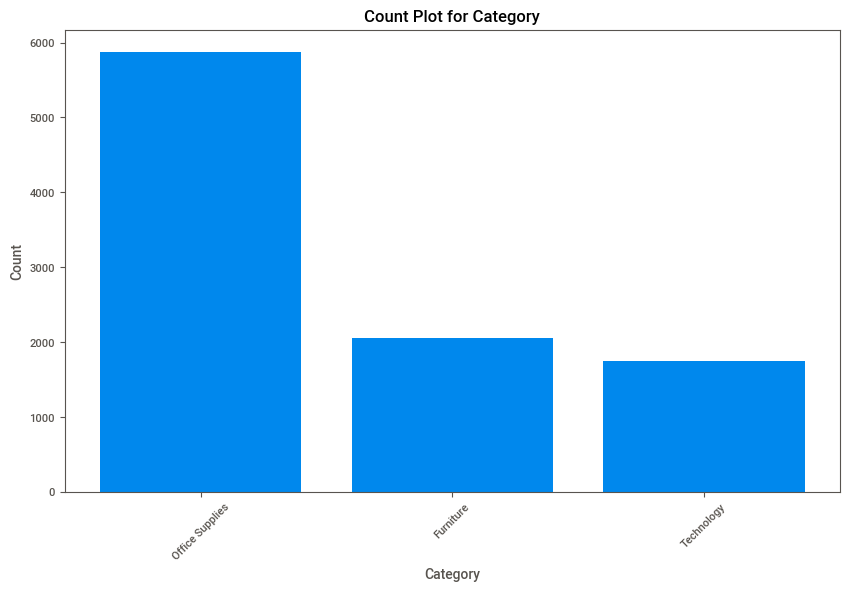


##################################################
##############Sub-Category Details ###############
              Sub-Category   Ratio(%)
Sub-Category                         
Binders               1474  15.231993
Paper                 1338  13.826599
Furnishings            931   9.620750
Phones                 864   8.928387
Storage                830   8.577038
Art                    785   8.112018
Accessories            752   7.771003
Chairs                 592   6.117598
Appliances             456   4.712204
Labels                 357   3.689160
Tables                 304   3.141469
Envelopes              248   2.562778
Bookcases              219   2.263098
Fasteners              214   2.211429
Supplies               178   1.839413
Machines                86   0.888705
Copiers                 49   0.506355

Sub-Category has 17 unique values.
##################################################



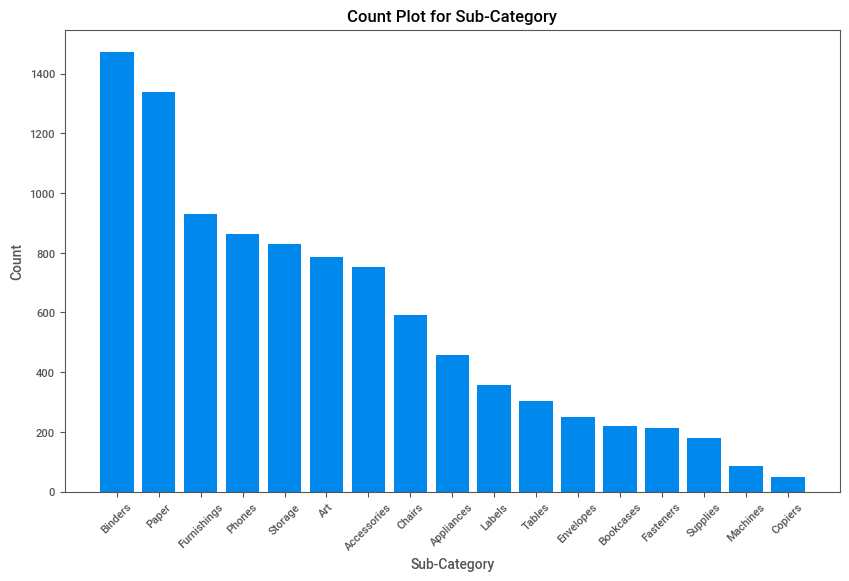

In [144]:
for col in ["Ship Mode", "Segment", "State", "Region", "Category", "Sub-Category"]:
  cat_details(df,col,plot=True)

In [145]:
def num_details(dataframe, col_name, plot=False, quantiles=[0.05,0.10,0.20,0.50,0.60,0.80,0.90,0.95,0.99]):
  if plot:
    dataframe[col_name].hist(bins=20)
    plt.xlabel(col_name)
    plt.ylabel(col_name)
    plt.show(block=True)

  #calculate the length of the summary line
  summary_length = len(col_name)+len(" Details ")
  border_length= max(50, summary_length + 4)

  #create border lines
  top_border='#'*border_length
  middle_border=f"{'#' * 10}{col_name} Details{'#'*10}".center(border_length,'#')
  bottom_border='#'*border_length

  #print summary
  print(f"\n{top_border}")
  print(middle_border)
  print(dataframe[col_name].describe(percentiles=quantiles).T, end="\n\n")
  print(f"{bottom_border}\n")

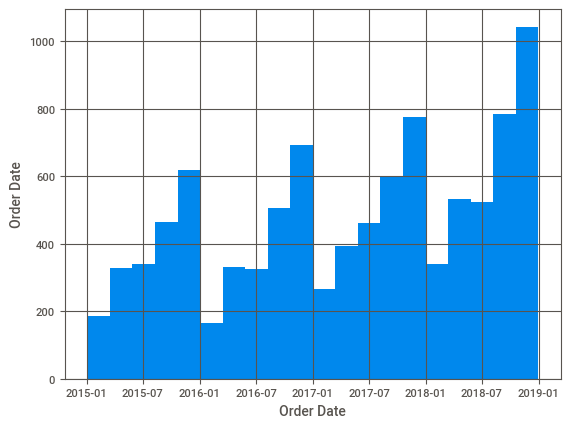


##################################################
################Order Date Details################
count                             9677
mean     2017-05-01 09:22:02.517309184
min                2015-01-03 00:00:00
5%                 2015-05-21 19:12:00
10%                2015-09-07 00:00:00
20%                2016-01-03 00:00:00
50%                2017-06-26 00:00:00
60%                2017-11-04 00:00:00
80%                2018-07-20 00:00:00
90%                2018-10-23 00:00:00
95%                2018-11-28 00:00:00
99%                2018-12-22 05:45:36
max                2018-12-30 00:00:00
Name: Order Date, dtype: object

##################################################



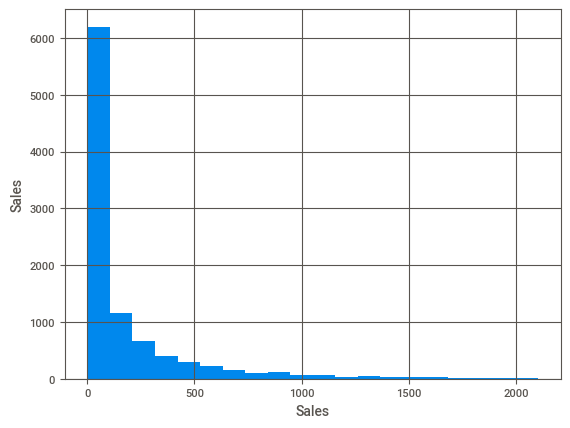


##################################################
##################Sales Details###################
count    9677.000000
mean      181.523961
std       305.877098
min         0.444000
5%          4.928000
10%         7.858800
20%        13.499200
50%        52.200000
60%        86.291200
80%       269.490000
90%       526.502800
95%       841.724800
99%      1569.780720
max      2104.550000
Name: Sales, dtype: float64

##################################################



In [146]:
for col in num_cols:
  num_details(df,col,plot=True)

Exploring Timeseries Charts

Line Plot

In [148]:
df['month']=pd.to_datetime(df['Order Date']).dt.to_period('M')
df.head()

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales,month
0,2015-01-03,Standard Class,DP-13000,Consumer,Houston,Texas,Central,OFF-PA-10000174,Office Supplies,Paper,16.448,2015-01
1,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-BI-10004094,Office Supplies,Binders,3.540,2015-01
2,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-ST-10002743,Office Supplies,Storage,272.736,2015-01
3,2015-01-04,Standard Class,PO-19195,Home Office,Naperville,Illinois,Central,OFF-LA-10003223,Office Supplies,Labels,11.784,2015-01
4,2015-01-05,Standard Class,MB-18085,Consumer,Philadelphia,Pennsylvania,East,OFF-AR-10003478,Office Supplies,Art,19.536,2015-01


In [149]:
mdf=df.groupby('month')['Sales'].sum()
mdf=pd.DataFrame(mdf)
mdf['time']=np.arange(len(mdf.index))
mdf.head()

,Sales,time
month,,
2015-01,11631.887,0
2015-02,4519.892,1
2015-03,29067.387,2
2015-04,23742.805,3
2015-05,20928.373,4


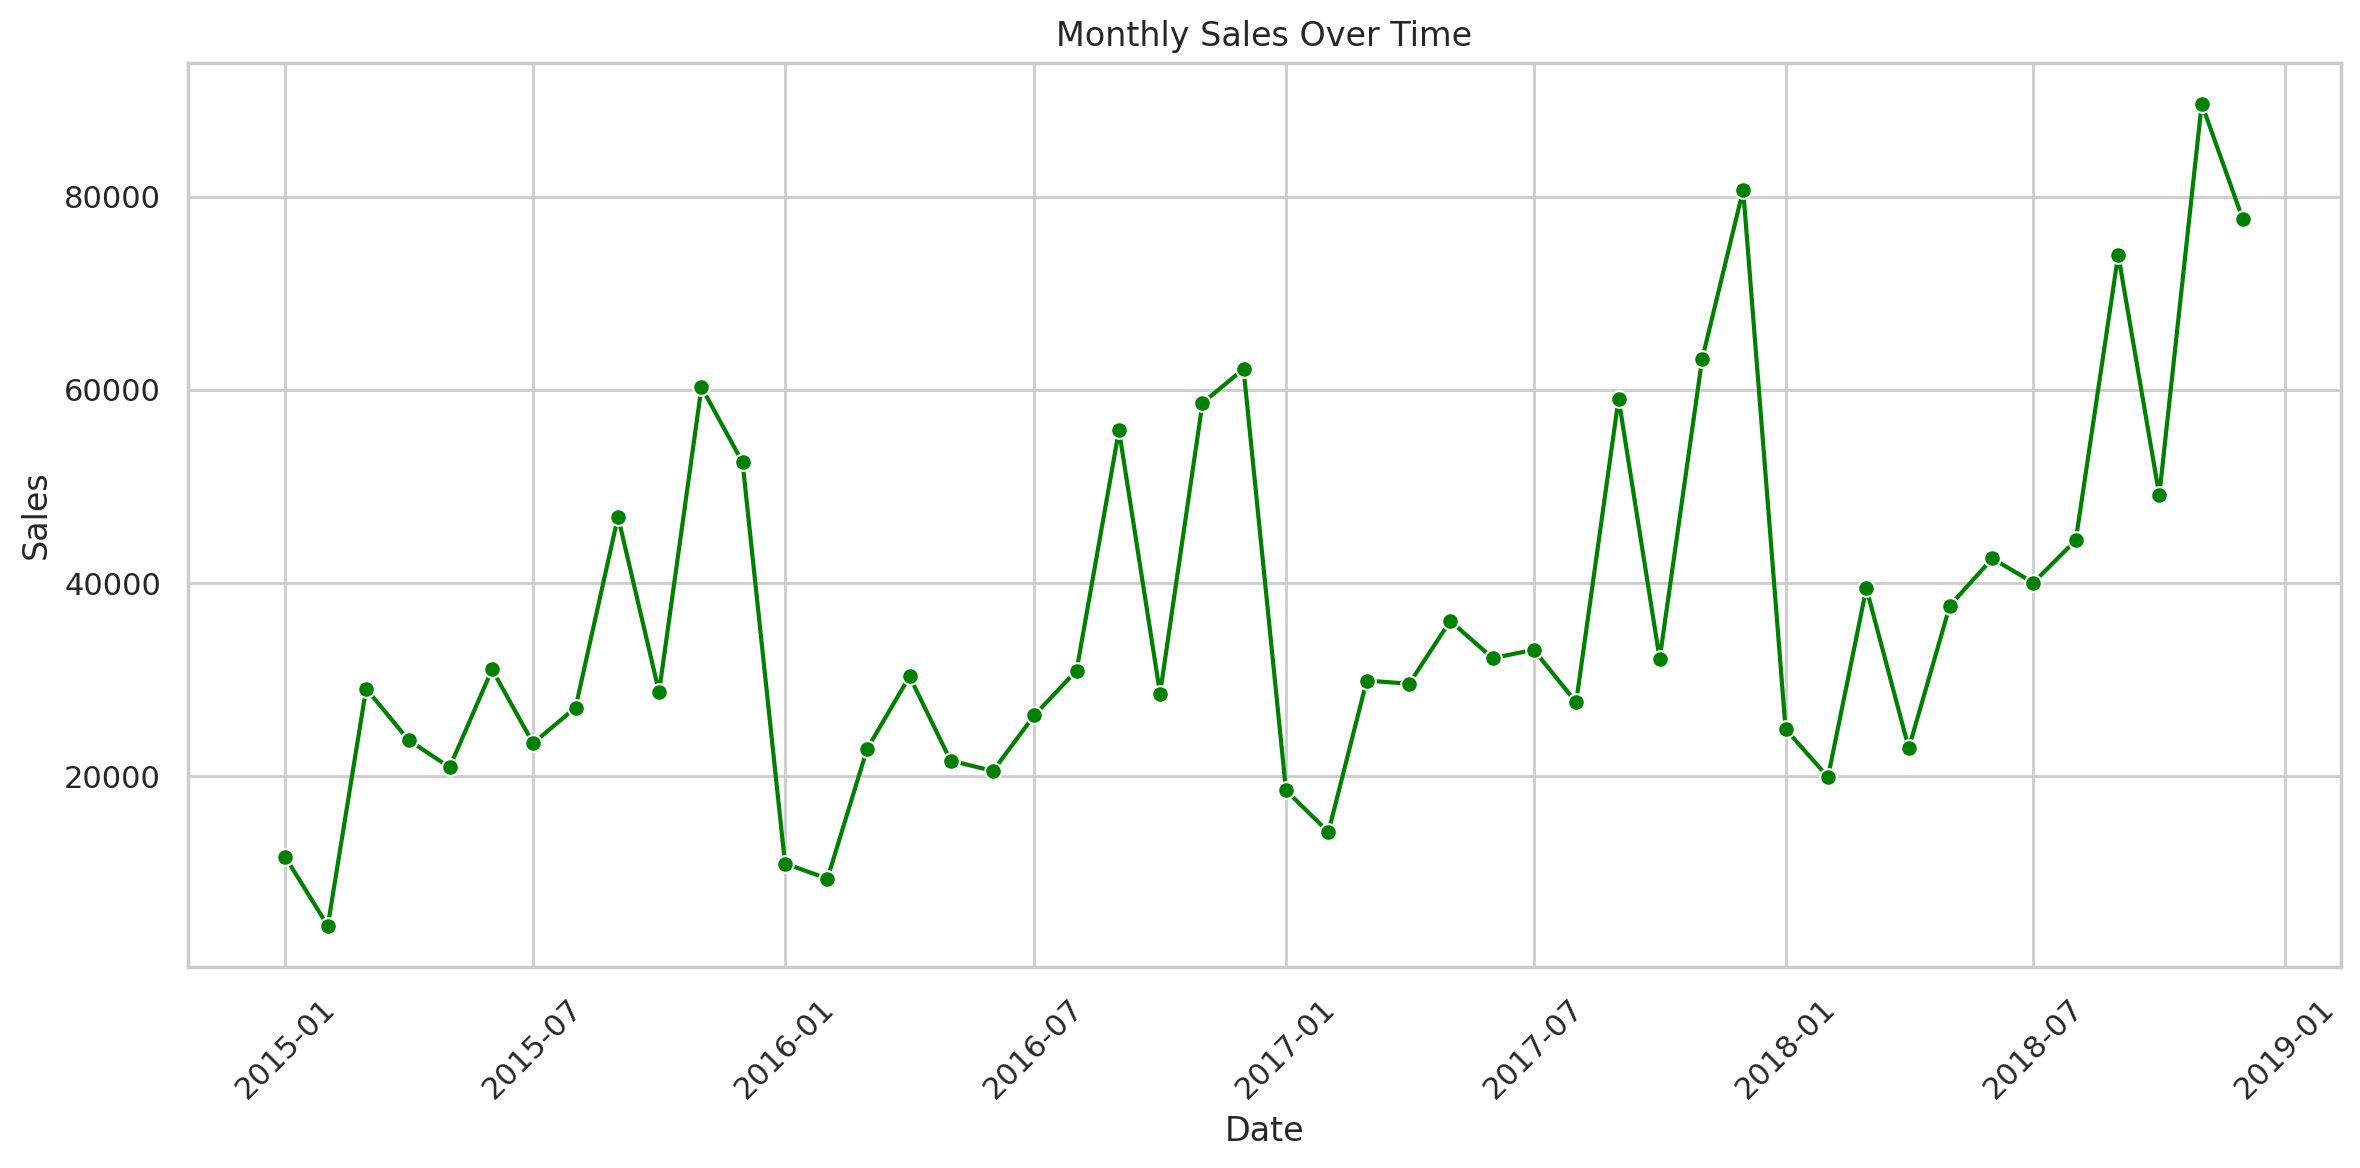

In [150]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,6),dpi=200)

if isinstance(mdf.index, pd.PeriodIndex):
  mdf.index=mdf.index.to_timestamp()

sns.lineplot(data=mdf,x=mdf.index,y='Sales',marker='o',color='green')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Rolling Mean

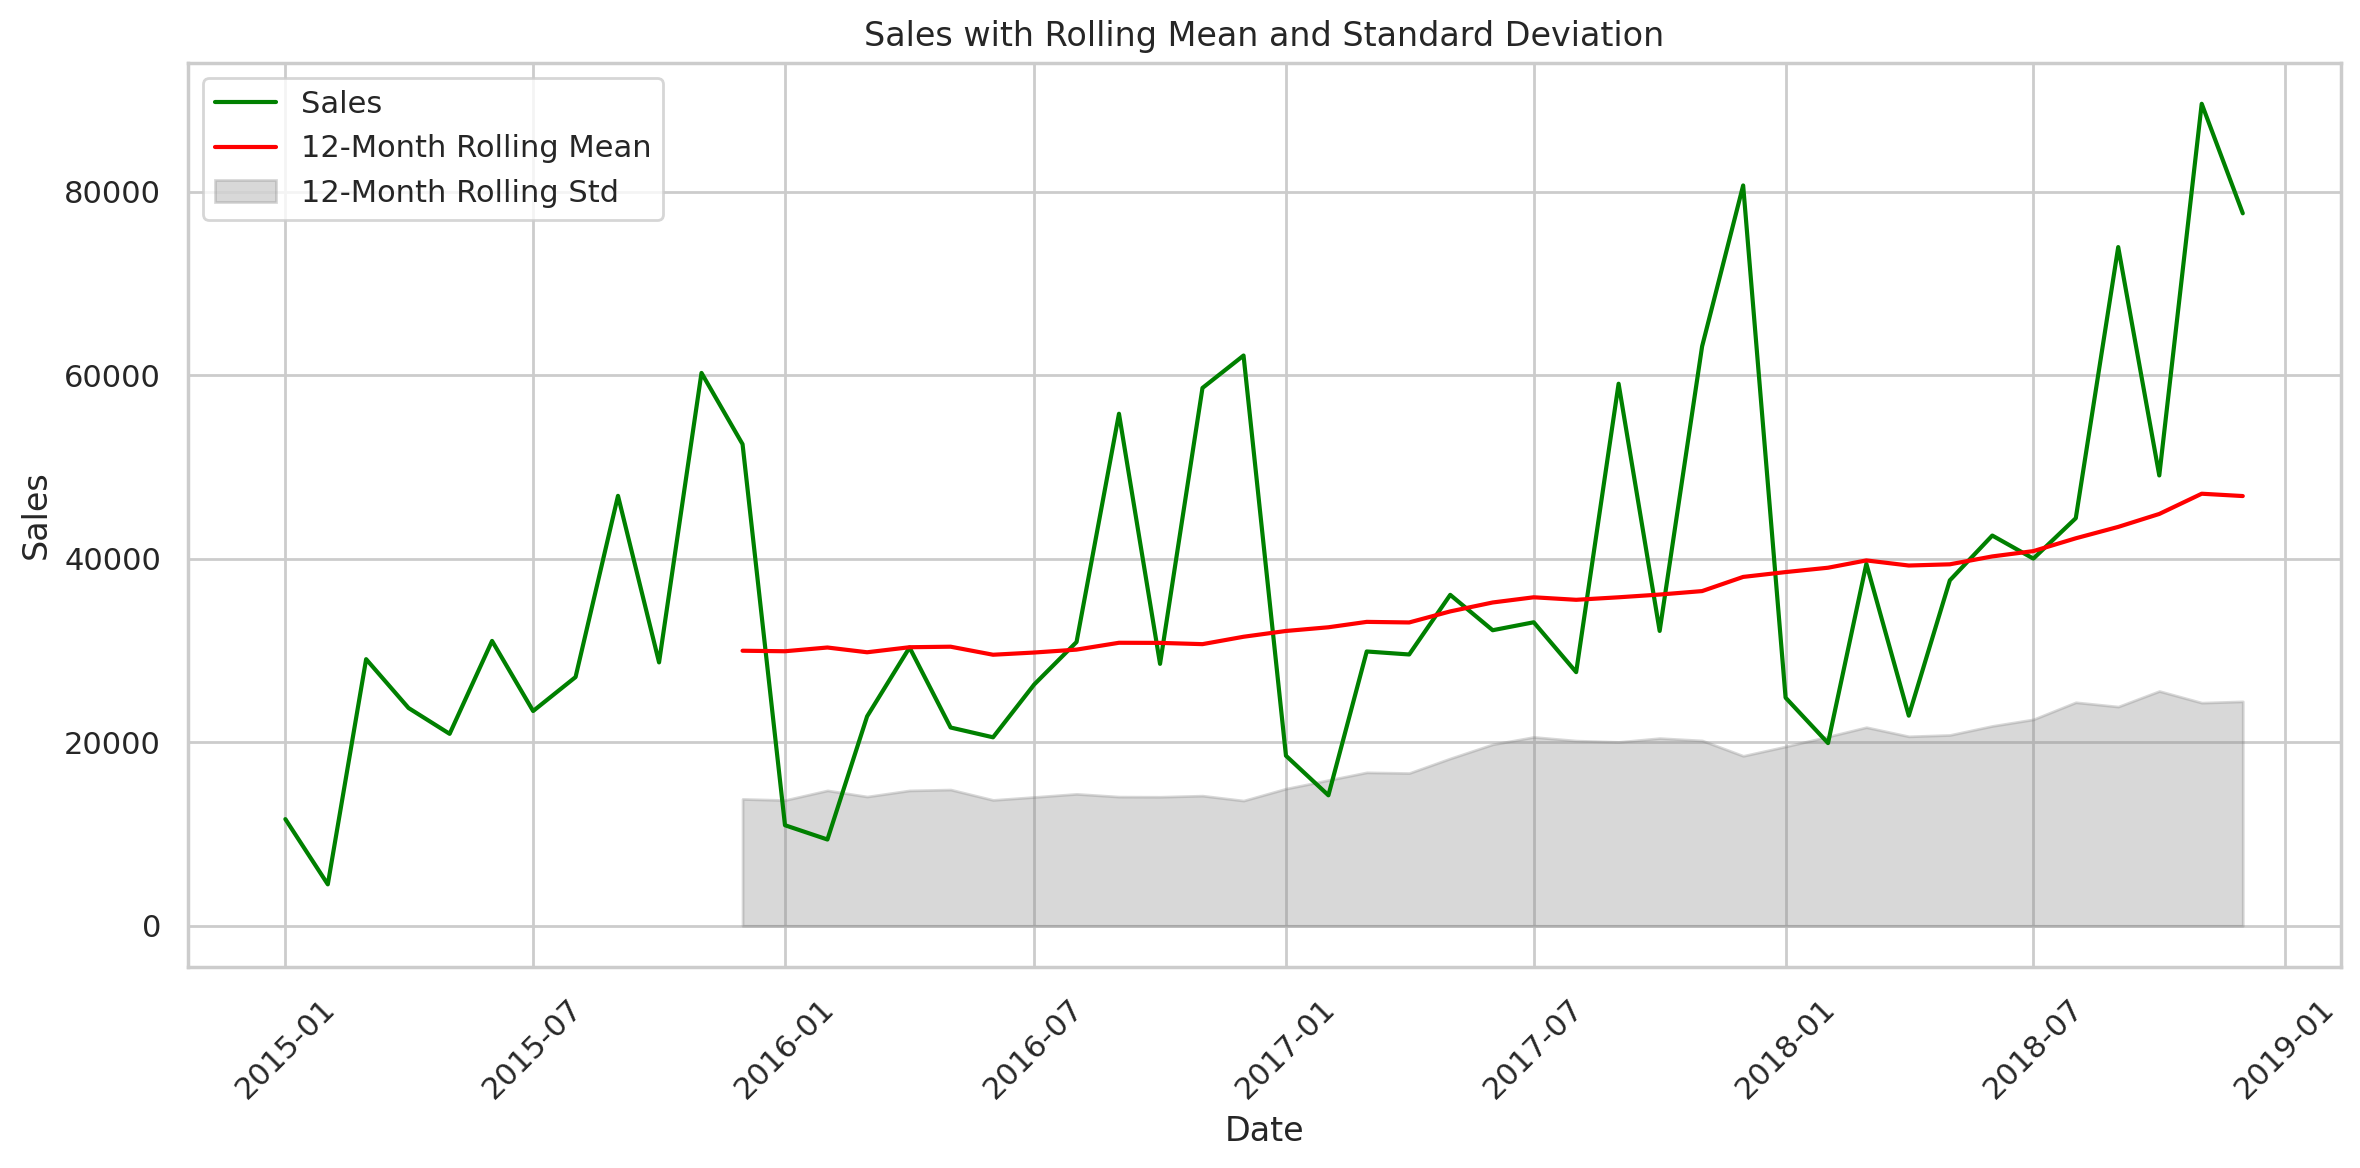

In [151]:
window_size=12
mdf['Rolling_Mean']=mdf['Sales'].rolling(window=window_size).mean()
mdf['Rolling_Std']=mdf['Sales'].rolling(window=window_size).std()

#Plot original sales data
plt.figure(figsize=(12,6),dpi=200)
sns.lineplot(data=mdf,x=mdf.index,y='Sales',label='Sales',color='green')

#Plot rolling mean
sns.lineplot(data=mdf,x=mdf.index,y='Rolling_Mean',label=f'{window_size}-Month Rolling Mean',color='red')

#Plot tolling standard deviation(shaded area for volatility)
plt.fill_between(mdf.index,mdf['Rolling_Mean']-mdf['Rolling_Std'],color='gray',alpha=0.3,label=f'{window_size}-Month Rolling Std')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales with Rolling Mean and Standard Deviation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()